![QuantConnect Logo](https://cdn.quantconnect.com/web/i/logo-small.png)
# QuantConnect Alpha Stream Analysis Notebook
#### Licensed Under QuantConnect Platform Service Agreement v1.0. Copyright QuantConnect 2020.
#### For more information; see the Open API Specification of Alpha Streams: https://app.swaggerhub.com/apis/QuantConnect/Alpha/0.83

## Introduction

QuantConnect Alpha Streams allows quantiative funds to search a database of algorithm authors; and instantly license the authors' strategies (`Alpha`). The license agreements and fee structure is already prenegotiated, and the standardized backtesting and live trading infrastructure can give funds confidence in the algorithm results. Upon licensing an Alpha the insights/signals are instantly delivered to the fund in realtime.

## Terminology
 - `Alpha`     - Strategy for licensing.
 - `Author`    - QuantConnect member and creator of the Alpha. 
 - `Insight`   - Trade signal from an algorithm; consisting of an asset, direction, magnitude and confidence.
 - `Project`   - Properties of the project which submitted the `Alpha` 

## Alpha Analysis Demo

### 1. Setup the SDK: Login with Client Credentials
We have written a full abstraction and SDK for the API which you can quickly import into your investment process. To start create a new instance of the `AlphaStreamClient` with your clientId and token.

In [2]:
# Prepare the import. This step is needed of AlphaStream is not installed yet\n",
try:
    import AlphaStream
except ImportError:
    import os, sys
    from os.path import dirname
    sys.path.append(dirname(os.getcwd()))

In [3]:
# Import Python SDK Client Library 
from AlphaStream import AlphaStreamClient 

# Define the clientId and API access token:
clientId  = "YOUR_ID"
token     = "YOUR_TOKEN"

# Create a new instance of the client module:
client = AlphaStreamClient(clientId, token)

### 2. Get the Alpha to Analyze by ID
You can use the AlphaStreamClient instance to get detailed information about a specific Alpha.

In [4]:
# Define Alpha ID
alphaId = "27c098768270c2259a9737a41"

# Get the Alpha using the AlphaStreamClient
alpha = client.GetAlphaById( alphaId )

## 3. Perform a Cursory Examination of the Alpha
Examine some basic information about the Alpha, suchs as days live, Sharpe ratio, asset classes, and more.

In [5]:
# Print various Alpha properties
daysLive = (datetime.utcnow()-alpha.ListedTime).days
print(f'{alpha.Name}\n  Days Live:     {daysLive}\n  Sharpe Ratio:  {alpha.SharpeRatio}\n  Asset Classes: {", ".join(alpha.AssetClasses)}\n  Tags:          {", ".join(alpha.Tags)}\n  Description:\n    {alpha.Description}')

Liquid Silicon
  Days Live:     14
  Sharpe Ratio:  -1.22501934281
  Asset Classes: equity
  Tags:          Immediate, Manual Selection, Equal Weighting, Drawdown Capped, Period Rebalance, Technical Alpha
  Description:
    This alpha trades daily four of the most liquid components of the S&P500 : Facebook (FB), Amazon, (AMZN), Microsoft (MSFT) and Apple (AAPL). The system identifies technical signals for either going long or short the above securities. A fifth security (QID) is also part of the portfolio to provide risk mitigation, along with the usual stop-loss mechanisms.


## 4. Analyze the Equity Curve
Fetch the Alpha's equity curve and do some basic visual analysis.

#### To run the examples below, please run the Appendix cell at the bottom of the notebook first

In [6]:
# Initialize local equity class to assist in plotting
equity = Equity(alphaId, client, benchmarkTicker = "SPY")

### Equity Curve
Alpha's can be submitted with varying levels of initial capital, but this will give a basic idea of its combined backtest and live performance.

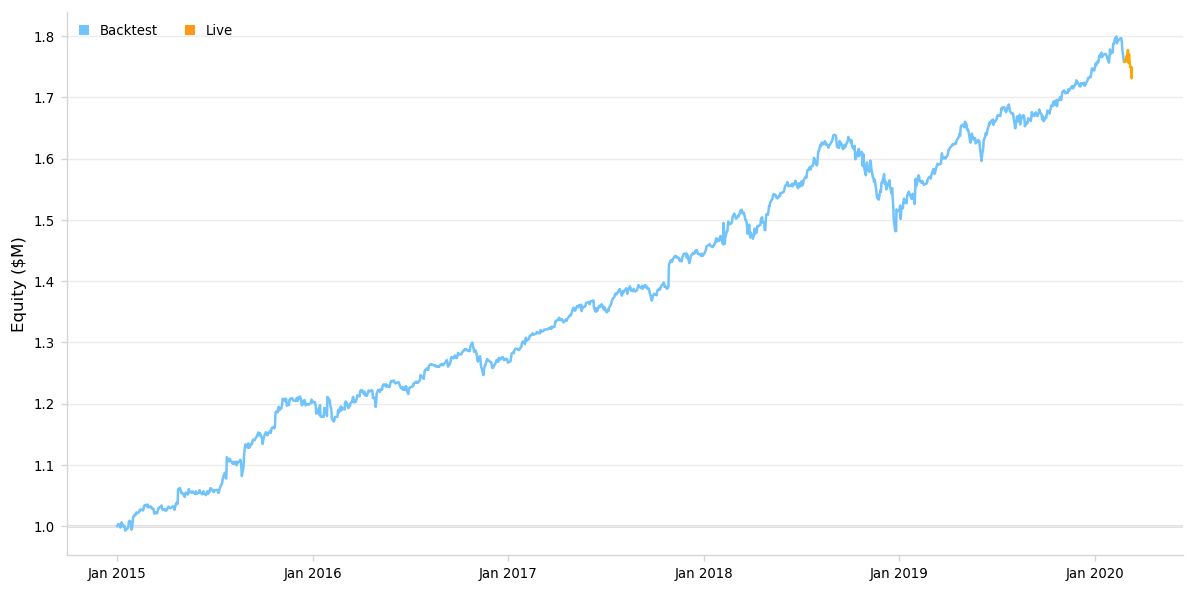

In [7]:
equity.GetEquityCurve()

### Cumulative Returns
View the Alpha's cumulative returns versus the benchmark.

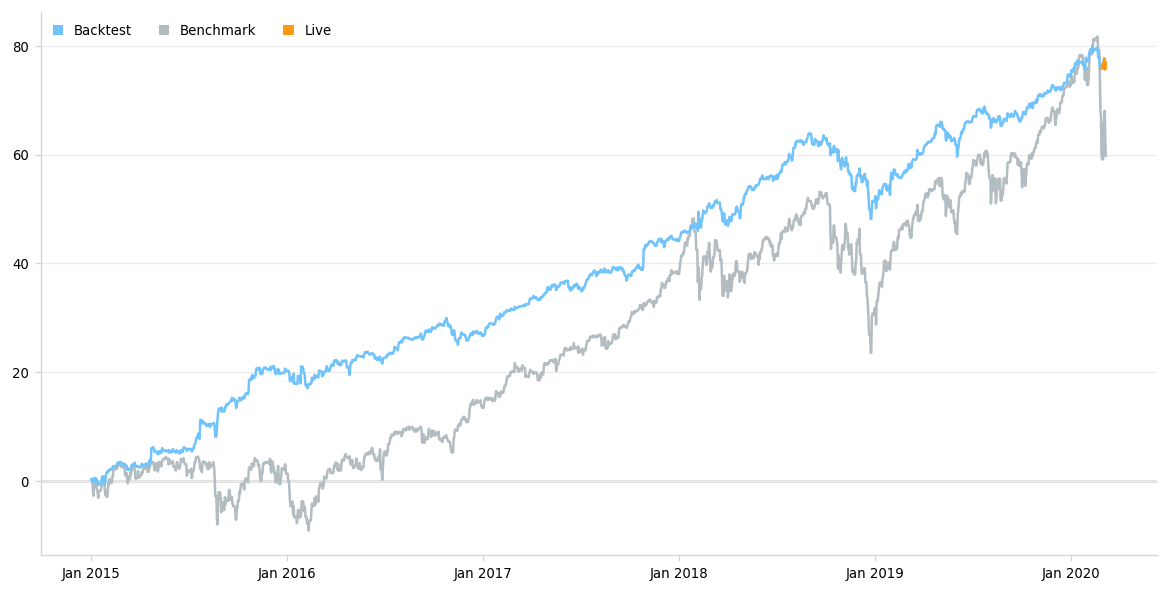

In [8]:
equity.GetCumulativeReturns()

### Annual Returns
Get the annual returns of the Alpha.

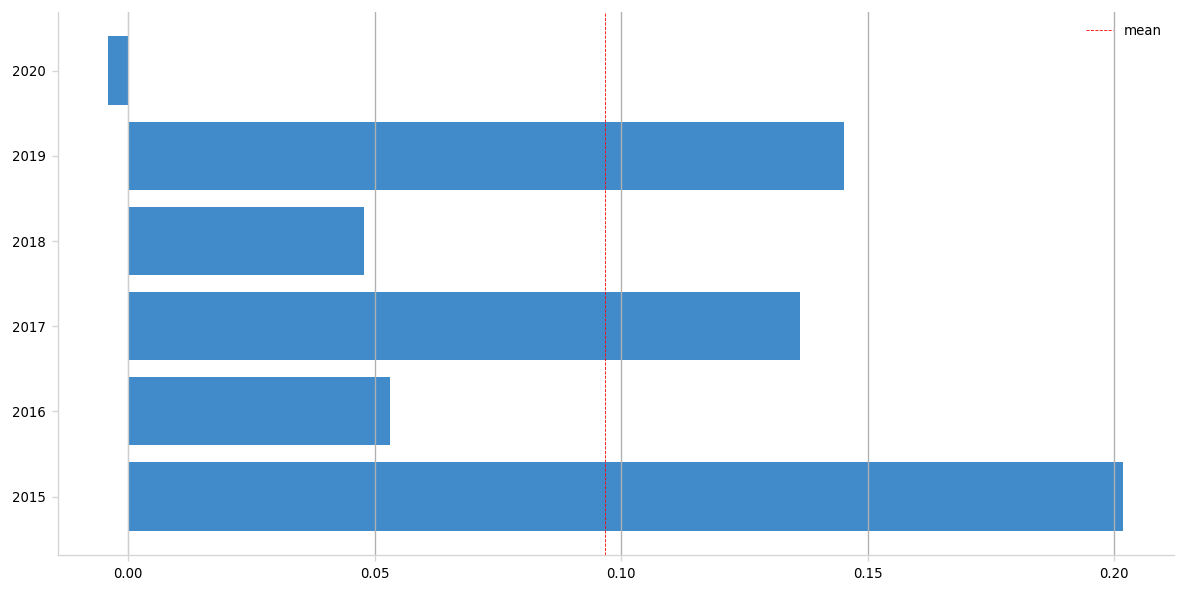

In [9]:
equity.GetAnnualReturns()

### Drawdown
Examine the Alpha's drawdown, highlighting the 5 largest drawdowns.

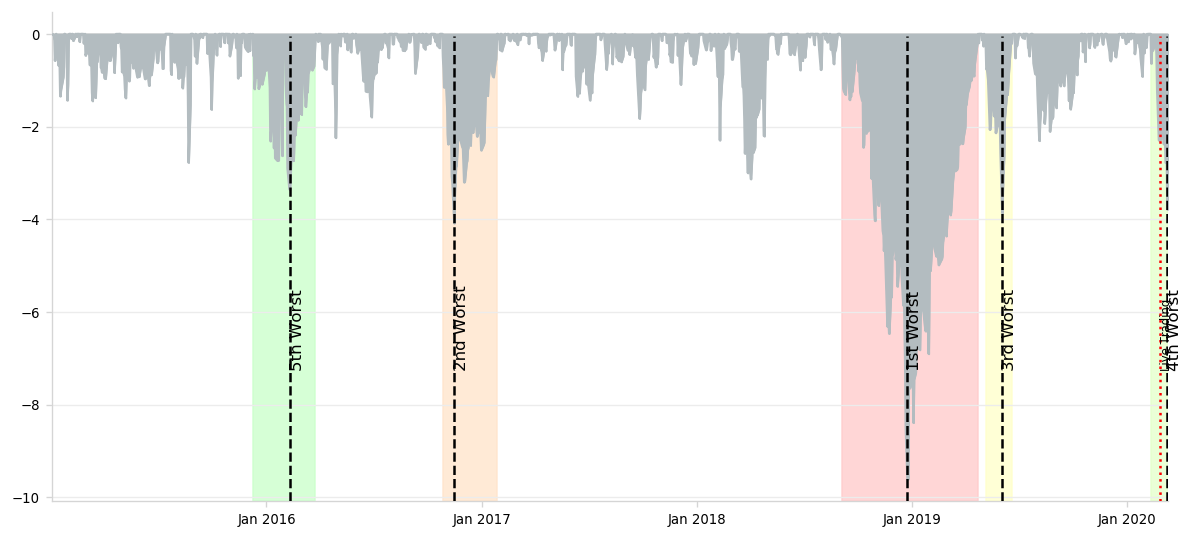

In [10]:
equity.GetDrawdown()

### Daily Returns
Get and plot the daily returns of the Alpha.

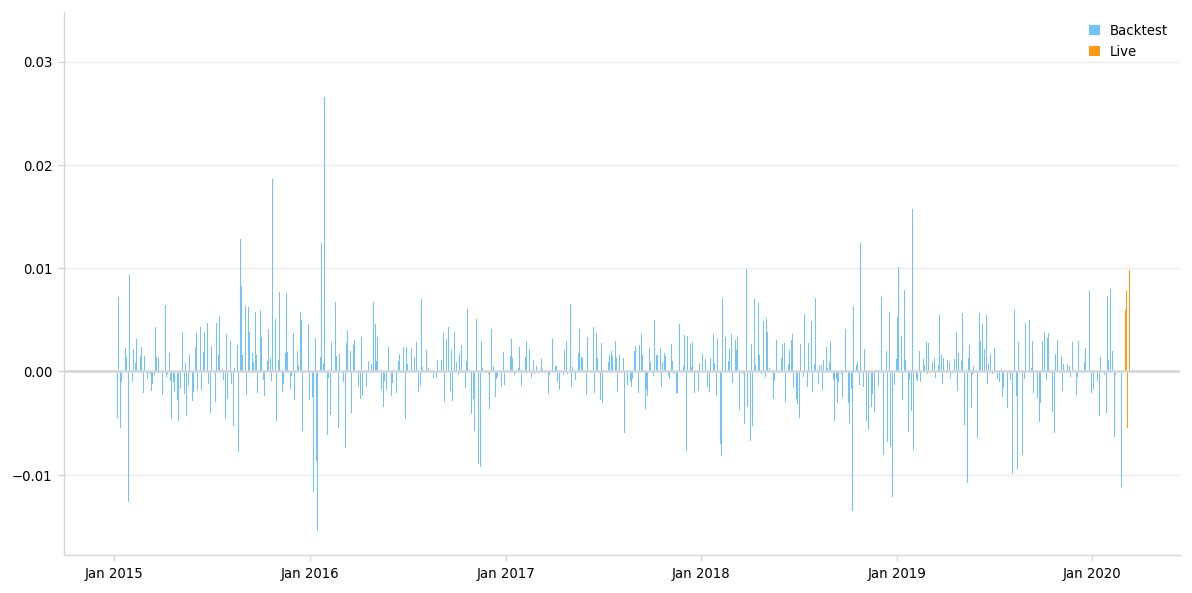

In [11]:
equity.GetDailyReturns()

### Rolling 6-month Sharpe ratio
Plot the annualized Sharpe ratio calculated on a rolling 6-month basis.

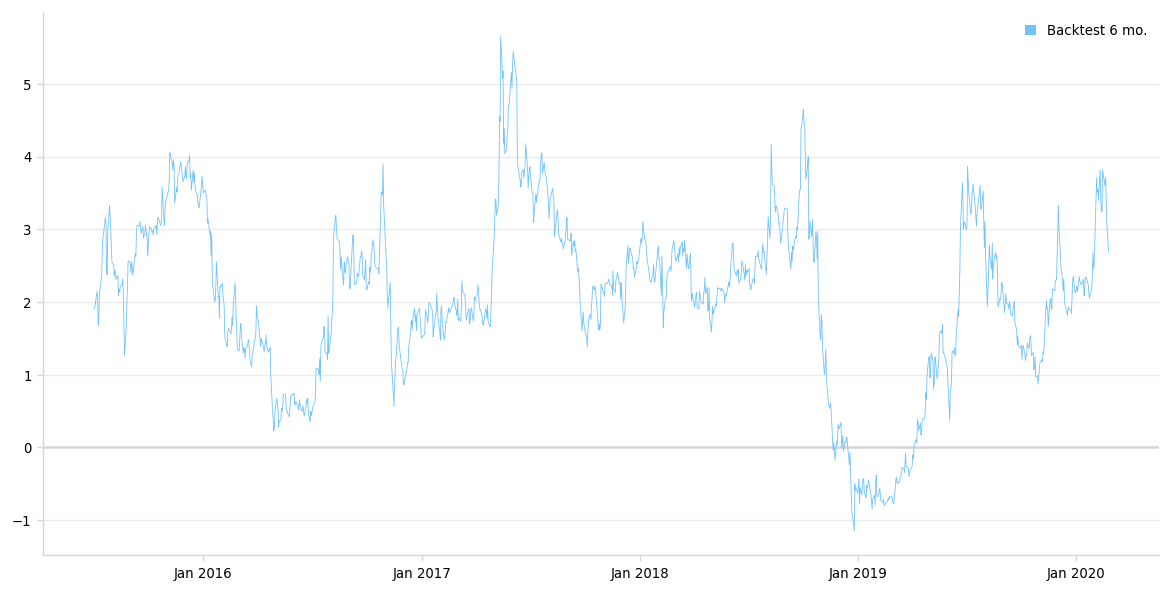

In [12]:
equity.GetRollingSharpeRatio()

### Rolling 6-month Beta
Plot the Alpha's beta on a rolling 6-month basis.

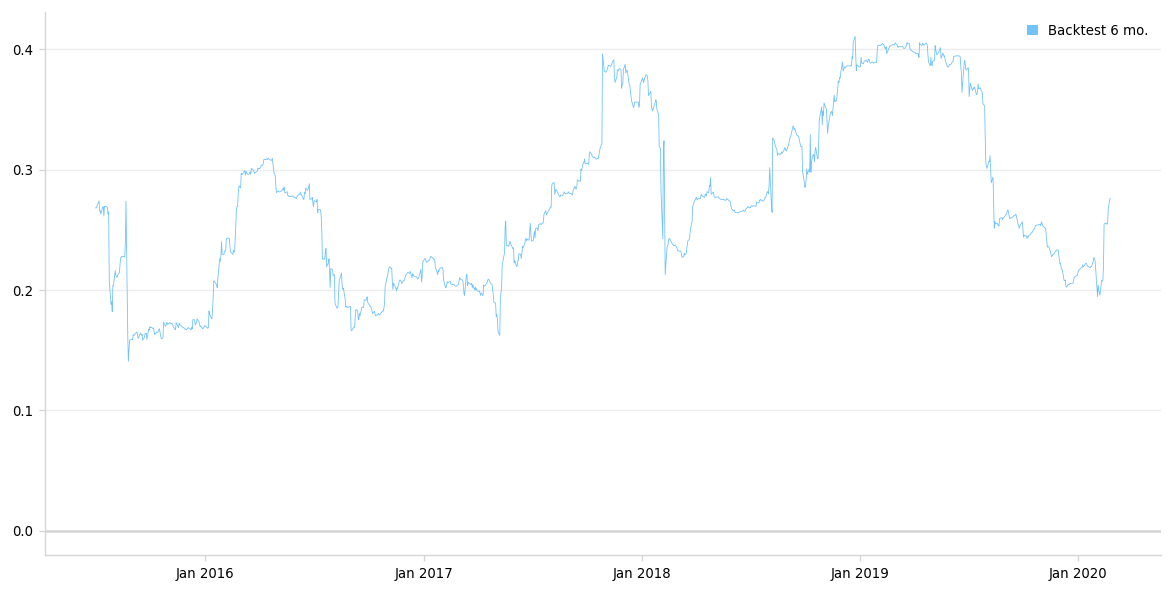

In [13]:
equity.GetRollingBeta()

## 5. Inspect the Insights
Insights are the Alpha's "predictions". We can analyze the Insights based on a number of properties, such as the insight distribution per symbol, the frequency over time, and the weights assigned to each symbol (if applicable).

In [25]:
# Create instance of local insight class to assist with plotting
insight = Insights(alphaId, client)

### Distribution of Insight Symbols
Fetch all of the insights per symbol and plot their frequency as a pie chart.

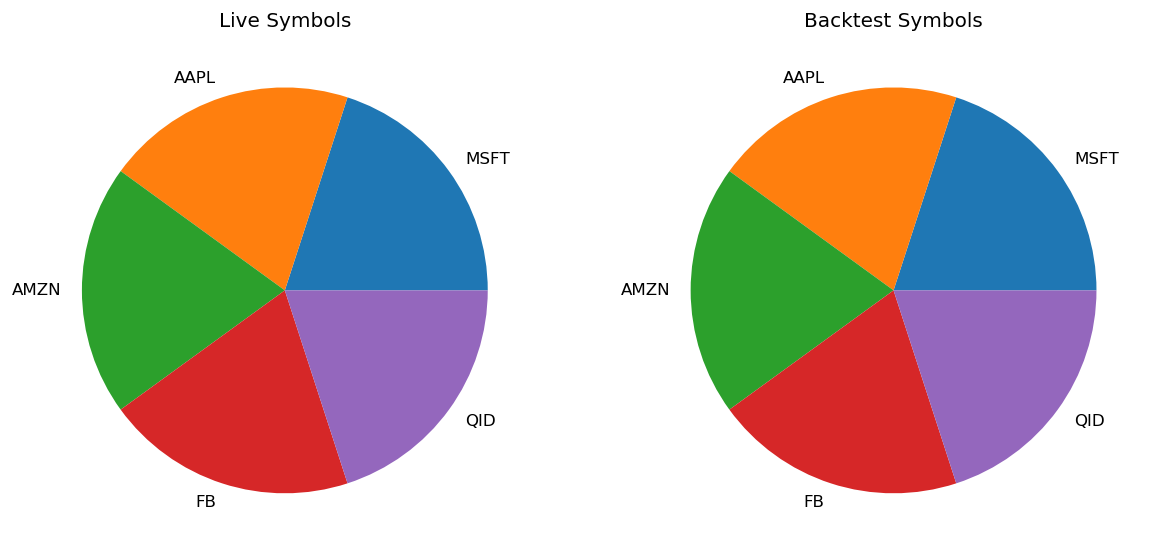

In [26]:
insight.GetInsightSymbols()

### Insight Frequency
Visualize the number of Insights emitted per month.

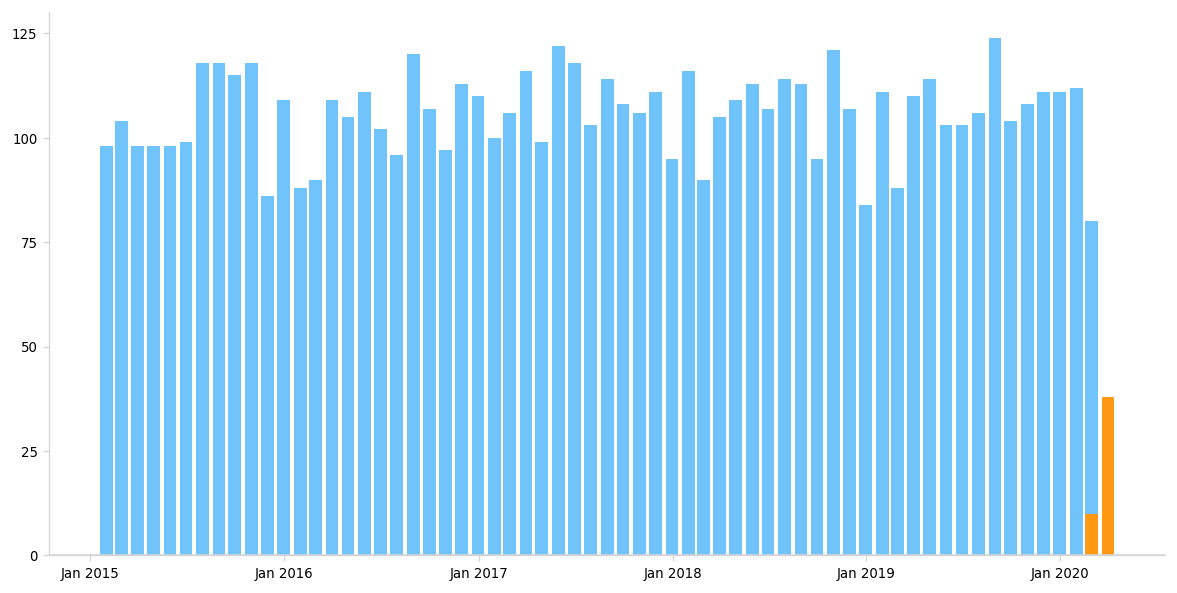

In [27]:
insight.GetInsightsOverTime()

### Insight Direction
View the percent of total Insights emitted in each direction (Up, Down, and Flat).

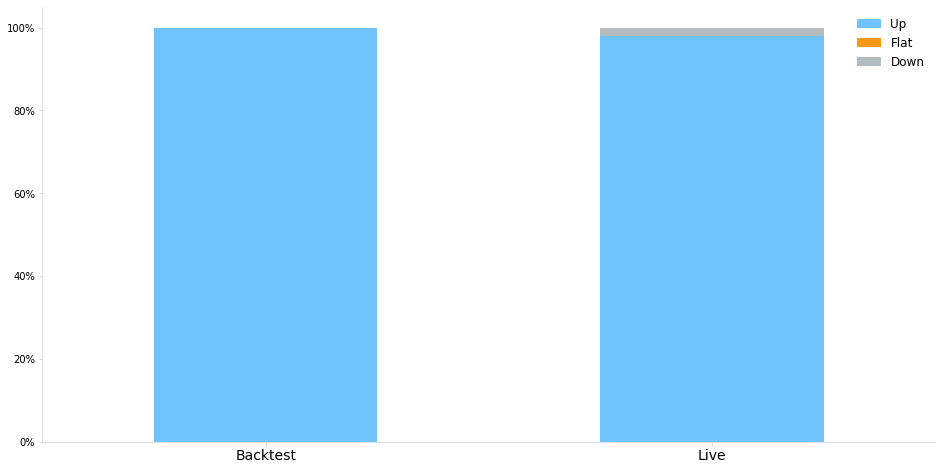

In [28]:
insight.GetInsightDirections()

### Insight Weights
Get the Insight weight of each symbol over time, aggregated by monthly average. Displays as a stackplot to better understand total allocation. (Note: Not all Alphas emit Insights with weights, but this is standard practice going forward).

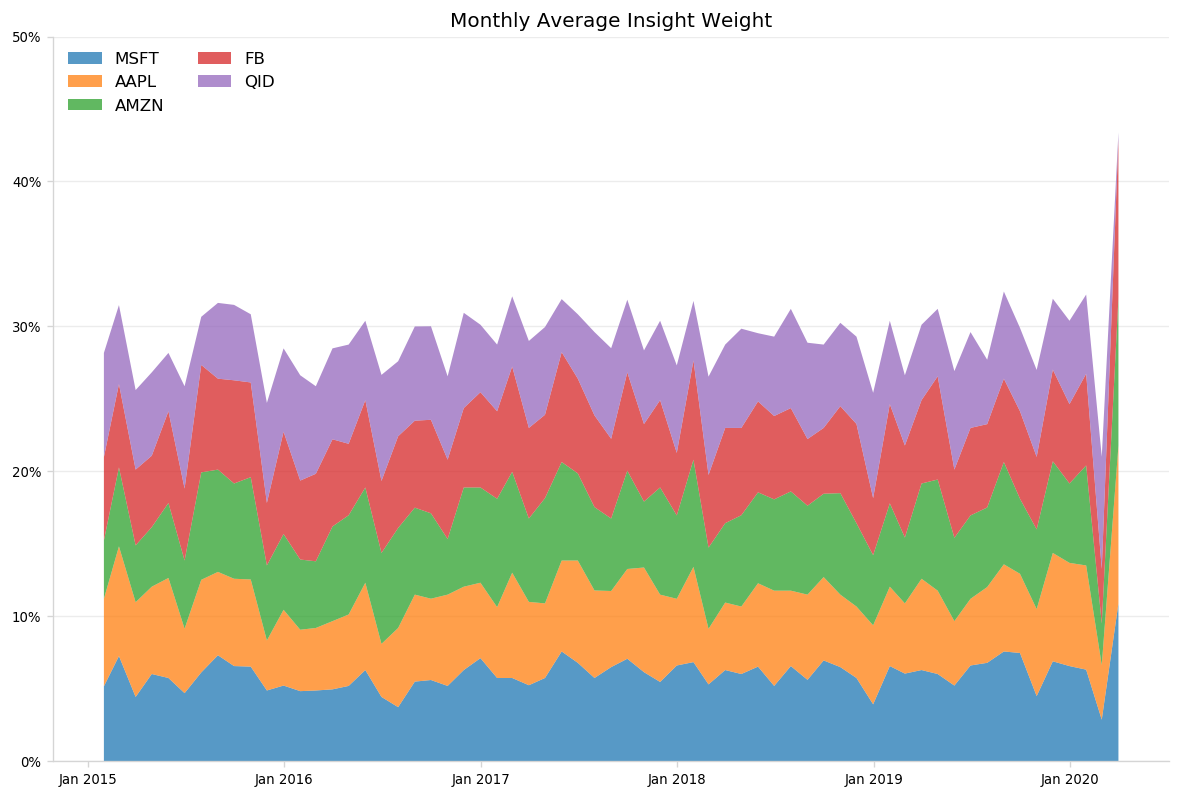

In [29]:
insight.GetInsightWeights()

## 6. Write Custom Analysis Functions
You can use the API to pass inputs into your own analysis functions to get metrics not directly tied to the Alpha.

In [19]:
# Get backtest length in days
GetBacktestLength(client, alphaId)

1895

In [20]:
# Get the maximum backtest drawdown
GetMaxDrawdown(client, alphaId, live = False)

0.096

In [21]:
# Get the maximum live drawdown
GetMaxDrawdown(client, alphaId, live = True)

0.026

In [22]:
# Get the average duration of the Insights
GetAverageInsightDuration(client, alphaId, insight)

24.0

In [23]:
# Get the correlation of the Alpha returns to the benchmark returns
GetBenchmarkCorrelation(client, alphaId, equity)

0.511

## Appendix
Code necessary to run the cells above

In [24]:
# All of our necessary imports
import re
import sys
import json
import requests
import operator
import numpy as np
import pandas as pd
from math import ceil
from time import time, sleep
from itertools import groupby
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from scipy.stats.stats import pearsonr
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
from dateutil.relativedelta import relativedelta
from pandas.plotting import register_matplotlib_converters
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

register_matplotlib_converters()

# Get the Alpha's backtest length
def GetBacktestLength(client, alphaId):
    equityCurve = client.GetAlphaEquityCurve(alphaId)
    diff = (equityCurve.index.to_pydatetime()[-1].date() - equityCurve.index.to_pydatetime()[0].date()).days
    return diff

# Get Alpha's maximum drawdown
def GetMaxDrawdown(client, alphaId, live = False):
    equityCurve = client.GetAlphaEquityCurve(alphaId)
    if live:
        equityCurve = equityCurve.loc[equityCurve['sample'] == 'live trading']
    else:
        equityCurve = equityCurve.loc[equityCurve['sample'] == 'in sample']
    curve = equityCurve['equity'].values
    i = np.argmax(np.maximum.accumulate(curve) - curve)
    j = np.argmax(curve[:i])
    return round(abs((curve[i]/curve[j]) - 1), 3)

# Get the Alpha's average insight duration
# While not strictly equal, this is a good proxy for average holding period
def GetAverageInsightDuration(client, alphaId, insight):
    insights = insight.insights
        
    duration = np.median([(x.CloseTime - x.CreatedTime).total_seconds() for x in insights]) / 3600
    return duration

# Get Alpha's correlation to SPY as a proxy for the SP500 index
def GetBenchmarkCorrelation(client, alphaId, equity):
    equityCurve = client.GetAlphaEquityCurve(alphaId)
    equityCurve = equityCurve.drop('sample', axis = 1)
    alphaReturns = equityCurve.resample('D').mean().pct_change().dropna()
    
    benchmark = equity.benchmark.copy()
    benchmarkReturns = benchmark.resample('D').mean().pct_change().dropna()

    data = benchmarkReturns.join(alphaReturns, how = 'outer').dropna()
    return round(data.corr()[data.columns[0]][1], 3)

# Code to get benchmark data
def _get_crumbs_and_cookies(stock = None):
    """
    get crumb and cookies for historical data csv download from yahoo finance

    parameters: stock - short-handle identifier of the company

    returns a tuple of header, crumb and cookie
    """
    if stock is None:
        raise TypeError(f'Stock argument must be string')
    else:
        url = 'https://finance.yahoo.com/quote/{}/history'.format(stock)
    with requests.session():
        header = {'Connection': 'keep-alive',
                  'Expires': '-1',
                  'Upgrade-Insecure-Requests': '1',
                  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) \
                   AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36'
                  }

        website = requests.get(url, headers=header)
        soup = BeautifulSoup(website.text, 'lxml')
        crumb = re.findall('"CrumbStore":{"crumb":"(.+?)"}', str(soup))

        return (header, crumb[0], website.cookies)

# Update forex benchmark
def GetSGCTA():
    url = "https://wholesale.banking.societegenerale.com/fileadmin/indices_feeds/CTA_Historical.xls"
    with requests.session():
        website = requests.get(url)
        file = website.text.split('\n')[:-1]
    close = [line.split('\t')[1] for line in file[1:]]
    date = [datetime.strptime(line.split('\t')[0], '%Y/%m/%d') for line in file[1:]]
    data_frame = pd.DataFrame({'Date': date, 'Close': close})
    if not data_frame.empty:
        return data_frame
    else:
        raise Exception('SGCTA data frame empty.')

# Update equities benchmark
def GetBenchmark(ticker):
    start_date = '946684800'
    now = datetime.utcnow()
    end_date = int(datetime.timestamp(datetime(now.year, now.month, now.day, 0, 0, 0)))

    header, crumb, cookies = _get_crumbs_and_cookies(f'{ticker.upper()}')
    url = f"https://query1.finance.yahoo.com/v7/finance/download/{ticker.upper()}?period1={start_date}&period2={end_date}&interval=1d&events=history&crumb={crumb}"
    with requests.session():
        website = requests.get(url, headers=header, cookies=cookies)
        file = website.text.split('\n')[:-1]
    date = [datetime.strptime(line.split(',')[0], '%Y-%m-%d') for line in file[1:]]
    close = [float(line.split(',')[5]) for line in file[1:]]
    data_frame = pd.DataFrame({'Date': date, f'{ticker}': close})
    if not data_frame.empty:
        data_frame = data_frame.set_index('Date')
        data_frame.index = data_frame.index.to_pydatetime()
        return data_frame
    else:
        raise Exception(f'{ticker.upper()} data frame empty.')
        

        
        
        
        
        
        
        
        
        

# class to handle all insight-related plotting 
class Insights:
    def __init__(self, alphaId, client):
        self.alphaId = alphaId
        self.client = client
        self.backtestInsights = []
        self.liveInsights = []
        self.insights = []
        
        self.GetInsights()
    
    def GetInsights(self):
        hasData = True
        start = 0
        insights = []
        while hasData:
            responseInsights = client.GetAlphaInsights(alphaId, start)
            insights += responseInsights
            hasData = len(responseInsights)
            start += 100


        self.backtestInsights = [x for x in insights if x.Source == 'in sample']
        self.liveInsights = [x for x in insights if x.Source == 'live trading']
        self.insights = insights
    
    def GetInsightSymbols(self):
        # Separate insights by symbol
        backtestSymbols = list(set(x.Ticker.upper() for x in self.backtestInsights))
        backtestWeights = [backtestSymbols.count(x) for x in backtestSymbols]
        liveSymbols = list(set(x.Ticker.upper() for x in self.liveInsights))
        liveWeights = [liveSymbols.count(x) for x in liveSymbols]
        
        # Get!
        fig=plt.figure(figsize=(12, 6), dpi= 120)
        if len(liveWeights) > 0:
            ax1 = fig.add_subplot(121)
            ax1.pie(liveWeights, labels = liveSymbols)
            ax1.set_title('Live Symbols')
            ax2 = fig.add_subplot(122)
            ax2.pie(backtestWeights, labels = backtestSymbols)
            ax2.set_title('Backtest Symbols')
        else:
            plt.pie(backtestWeights, labels = backtestSymbols)
            plt.title('Backtest Symbols')
        plt.show()
        
    def GetInsightDirections(self):
        # Separate insights by direction
        directions = ['UP', 'FLAT', 'DOWN']
        backtestDirections = [x.Direction.upper() for x in self.backtestInsights]
        backtestBar = [backtestDirections.count(x)/len(backtestDirections) for x in directions]
        if len(self.liveInsights) > 0:
            liveDirections = [x.Direction.upper() for x in self.liveInsights]
            liveBar = [liveDirections.count(x)/len(liveDirections) for x in directions]

        up = [backtestBar[0]]
        flat = [backtestBar[1]]
        down = [backtestBar[2]]
        labels = ['Backtest']

        if len(self.liveInsights) > 0:
            labels += ['Live']
            up += [liveBar[0]]
            flat += [liveBar[1]]
            down += [liveBar[2]]


        df = pd.DataFrame({'Up':up, 'Flat':flat, 'Down':down}, index = labels)
        ax = df.plot(kind = 'bar', stacked = True, color = ['#71c3fc', '#ff9914', '#b3bcc0'], figsize=(16, 8))
        ax.tick_params(axis='both', which='major', labelsize=12, rotation = 0)
        plt.xticks(fontsize=14, rotation=0)
        ax.legend(fontsize=12, ncol=1, frameon = False)
        plt.setp(ax.spines.values(), color='#d5d5d5')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#d5d5d5')
        locs = ax.get_yticks()
        labs = [f'{int(x*100)}%' for x in locs]
        plt.yticks(ticks = [x for x in locs[:-1]], fontsize = 10, labels = labs[:-1])
        plt.show()
    
    def GetInsightsOverTime(self):
        groupedBacktesInsights = {k: len(list(g)) for k, g in
                                              groupby(sorted(self.backtestInsights, key=lambda x: x.CreatedTime),
                                                      key=lambda x: x.CreatedTime)}
        backtestInsightsOverTime = pd.Series(list(groupedBacktesInsights.values()), index = list(groupedBacktesInsights.keys()))
        data = backtestInsightsOverTime
        
        if len(self.liveInsights) > 0:
            groupedLiveInsights = {k: len(list(g)) for k, g in
                                          groupby(sorted(self.liveInsights, key=lambda x: x.CreatedTime),
                                                  key=lambda x: x.CreatedTime)}
            liveInsightsOverTime = pd.Series(list(groupedLiveInsights.values()), index = list(groupedLiveInsights.keys()))
            combinedIndex = list(backtestInsightsOverTime.index.values) + list(liveInsightsOverTime.index.values)        
            data = pd.concat([backtestInsightsOverTime, liveInsightsOverTime])
            data.index = combinedIndex
            liveData = liveInsightsOverTime.resample('M').sum()

        data = data.resample('M').sum()
        
        fig, ax = plt.subplots(figsize=(12, 6), dpi= 120)
        ax.bar(data.index.values, data.values, color='#71c3fc', width = 0.8*30)
        if len(self.liveInsights) > 0:
            ax.bar(liveData.index.values, liveData.values, color = '#ff9914', width = 0.8*30)
        plt.xticks(rotation=0, ha='center', fontsize=8)
        plt.yticks(fontsize=8)
        ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax.yaxis.set_major_locator(MaxNLocator(6))
        plt.axhline(y=0, color='#d5d5d5', zorder=1)
        plt.setp(ax.spines.values(), color='#d5d5d5')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#d5d5d5')
        plt.show()
        
    def GetInsightWeights(self):
        # Separate insights by weight
        weights = pd.DataFrame()
        symbols = list(set([x.Ticker.upper() for x in insight.insights]))
        for symbol in symbols:
            series = pd.Series([i.Weight for i in insight.insights if i.Ticker.upper() == symbol], index = [i.CreatedTime for i in insight.insights if i.Ticker.upper() == symbol])
            series.name = symbol.upper()
            weights = weights.join(series, how = 'outer')

        weights = weights.fillna(0).resample('M', convention = 'end').mean().fillna(0)
        data = [list(weights[col].values) for col in weights.columns]
        time = list(weights.index.to_pydatetime())
        labels = list(weights.columns)


        if len(time) == 0:
            fig = plt.figure()
            plt.show()

        fig = plt.figure(figsize=(12, 8), dpi= 120)
        ax = plt.gca()
        ax.stackplot(time, np.vstack(data), alpha = 0.75, labels = labels)
        plt.xticks(rotation = 0,ha = 'center', fontsize = 8)
        locs = ax.get_yticks()
        labs = [f'{int(x*100)}%' for x in locs]
        plt.yticks(ticks = [x for x in locs], fontsize = 8, labels = labs)
        plt.xlabel("")
        ax.axhline(y=0, color = 'black', linewidth = 0.5)
        ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
        plt.setp(ax.spines.values(), color='#d5d5d5')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#d5d5d5')
        plt.ylabel("")
        plt.xlabel("")
        cols = ceil(len(weights.columns)/3)
        plt.legend(loc = 'upper left', frameon = False, ncol = cols)
        ax.set_axisbelow(True)
        ax.yaxis.grid(True, color = "#ececec")
        plt.title('Monthly Average Insight Weight')
        plt.show()

        
        
        
        
        
        
        
        
        
        
        
        
        
        
# class to plot equity
class Equity:
    def __init__(self, alphaId, client, benchmarkTicker):
        self.alphaId = alphaId
        self.client = client
        
        equity = client.GetAlphaEquityCurve(alphaId)
        equity.index = [x for x in equity.index.to_pydatetime()]

        self.backtestCurve = equity.loc[equity['sample'] == 'in sample']['equity']
        self.backtestCurve.name = 'Backtest'
        self.liveCurve = equity.loc[equity['sample'] == 'live trading']['equity']
        self.liveCurve.name = 'Live'
        self.equityCurve = equity['equity']
        self.benchmarkTicker = benchmarkTicker
        
        torf = True
        while torf:
            try:
                self.benchmark = GetBenchmark(benchmarkTicker)
                torf = False
            except:
                continue
        
    def GetEquityCurve(self):
        # Get the equity curve
        backtestCurve = self.backtestCurve.copy()
        liveCurve = self.liveCurve.copy()
        data = backtestCurve.to_frame().append(liveCurve.to_frame(), sort = 'False')

        labels = ['Backtest', 'Live']
        rectangles = []
        colors = ["#71c3fc", "#ff9914"]
        for i in range(2):
            rectangles.append(plt.Rectangle((0, 0), 1, 1, fc=colors[i]))
        
        plt.figure(figsize=(12, 6), dpi= 120)
        ax = plt.gca()

        plt.plot(data.index.values, data['Backtest'].values/1e6, color = '#71c3fc', label = 'Backtest')
        plt.plot(data.index.values, data['Live'].values/1e6, color = 'orange', label = 'Live')
        
        plt.legend(rectangles, labels, handlelength=0.8, handleheight=0.8,
                  frameon=False, fontsize=8, ncol=len(labels), loc = 'upper left')
        plt.xticks(rotation=0, ha='center', fontsize=8)
        plt.yticks(fontsize=8)
        ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
        plt.axhline(y=1, color='#d5d5d5', zorder=1)
        plt.setp(ax.spines.values(), color='#d5d5d5')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#d5d5d5')
        plt.xlabel("")
        ax.yaxis.grid(True, color="#ececec")
        plt.ylabel('Equity ($M)', fontsize = 10)
        plt.legend(rectangles, labels, handlelength=0.8, handleheight=0.8,
                  frameon=False, fontsize=8, ncol=len(labels), loc = 'upper left')
        
        plt.show()
        
    def GetCumulativeReturns(self):
        # Add the SPY benchmark to the plot and plot cumulative returns
        benchmark = self.benchmark.copy().resample('D').mean()
        equityData = self.equityCurve.copy()
        liveCurve = self.liveCurve.copy()
        
        data = equityData.resample('D').mean().to_frame().join(benchmark, how = 'inner')
        data = ((data.pct_change() + 1).cumprod() - 1)*100

        liveIndex = liveCurve.index.values
        live = data.iloc[data.index.values >= liveCurve.index.values[0]]['equity']

        
        labels = ['Backtest', 'Benchmark', 'Live']
        rectangles = []
        colors = ["#71c3fc", "#b3bcc0", "#ff9914"]
        for i in range(3):
            rectangles.append(plt.Rectangle((0, 0), 1, 1, fc=colors[i]))
            
        
        plt.figure(figsize=(12, 6), dpi= 120)
        ax = plt.gca()
        plt.plot(data[f'{self.benchmarkTicker}'].index.values, data[f'{self.benchmarkTicker}'].values, color = '#b3bcc0', label = "SPY")
        plt.plot(data['equity'].index.values, data['equity'].values, color = '#71c3fc', label = "Backtest")
        plt.plot(live.index.values, live.values, color = '#ff9914', label = "Live")
        plt.legend(rectangles, labels, handlelength=0.8, handleheight=0.8,
                  frameon=False, fontsize=8, ncol=len(labels), loc = 'upper left')
        plt.xticks(rotation=0, ha='center', fontsize=8)
        plt.yticks(fontsize=8)
        ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax.yaxis.set_major_locator(MaxNLocator(6))
        plt.axhline(y=0, color='#d5d5d5', zorder=1)
        plt.setp(ax.spines.values(), color='#d5d5d5')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#d5d5d5')
        plt.ylabel("")
        plt.xlabel("")
        ax.yaxis.grid(True, color="#ececec")
        plt.show()
        
    def GetAnnualReturns(self):
        years = list(set([x.year for x in self.equityCurve.index.to_pydatetime()]))
        data = equity.equityCurve.copy()
        returns = []
        for year in years:
            df = data.loc[[x.year == year for x in data.index.to_pydatetime()]]
            ret = (df[-1]/df[0]) - 1
            returns.append(ret)
        time = years

        plt.figure(figsize=(12, 6), dpi= 120)
        ax = plt.gca()
        ax.barh(time, returns, color = ["#428BCA"])
        fig = ax.get_figure()
        plt.xticks(rotation=0, ha='center', fontsize=8)
        plt.yticks(fontsize=8)
        plt.axvline(x=0, color='#d5d5d5', linewidth=0.5)
        vline = plt.axvline(x=np.mean(returns), color="red", ls="dashed", label="mean", linewidth=0.5)
        plt.legend([vline], ["mean"], loc='upper right', frameon=False, fontsize=8)
        plt.setp(ax.spines.values(), color='#d5d5d5')
        plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#d5d5d5')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.xlabel("")
        plt.ylabel("")
        ax.xaxis.grid(True)
        plt.show()
        
    def GetDrawdown(self):
        data = equity.equityCurve.copy().to_frame()
        data["Drawdown"] = 1
        lastPeak = data.iloc[0,0]
        for i in range(len(data)):
            if data.iloc[i,0] < lastPeak:
                data.iloc[i,1] = data.iloc[i,0]/lastPeak
            else:
                lastPeak = data.iloc[i,0]
        data["DDGroup"] = 0
        tmp = 0
        for i in range(1,len(data)):
            if data.iloc[i,1] != 1:
                data.iloc[i,2] = tmp
            else:
                continue
            if data.iloc[i-1,1] == 1:
                tmp += 1
                data.iloc[i,2] = tmp
        data["index"] = [i for i in range(len(data))]
        tempFrame = pd.DataFrame.from_dict({'MDD':data.groupby([data["DDGroup"]])['Drawdown'].min(),
                                      'Offset':data.groupby([data["DDGroup"]])['Drawdown'].apply(lambda x: np.where(x == min(x))[0][0]),
                                      'Start':data.groupby([data["DDGroup"]])['index'].first(),
                                      'End':data.groupby([data["DDGroup"]])['index'].last()})
        tempFrame.drop(tempFrame.index[[0]],inplace = True)
        tempFrame.sort_values("MDD",inplace = True)
        data = (data["Drawdown"] - 1)*100
        data

        fig=plt.figure(figsize=(12, 6), dpi= 120)
        colors = ["#FFCCCCCC","#FFE5CCCC","#FFFFCCCC","#E5FFCCCC","#CCFFCCCC"]
        text = ["1st Worst","2nd Worst","3rd Worst","4th Worst","5th Worst"]
        ax = data.plot(color = '#b3bcc0',zorder = 2)
        ax.fill_between(data.index.values,data,0, color = '#b3bcc0',zorder = 3)
        for i in range(min(len(tempFrame),5)):
            start = data.index.values[int(tempFrame.iloc[i]["Start"])]
            end = data.index.values[int(tempFrame.iloc[i]["End"])]
            mid = data.index.values[int(tempFrame.iloc[i]["Offset"])+int(tempFrame.iloc[i]["Start"])]
            plt.axvspan(start, end,0,0.95, color = colors[i],zorder = 1)
            plt.axvline(mid, 0,0.95, ls = "dashed",color ="black", zorder = 4)
            plt.text(mid,min(data)*0.75,text[i], rotation = 90, zorder = 4)


        plt.axvline(self.liveCurve.index.values[0], 0, 0.95, ls = 'dotted', color='red', zorder = 4)
        plt.text(self.liveCurve.index.values[0], min(data)*0.75, "Live Trading", rotation = 90, zorder = 4, fontsize = 7)

        fig = ax.get_figure()
        plt.xticks(rotation = 0,ha = 'center', fontsize = 8)
        plt.yticks(fontsize = 8)
        plt.ylabel("")
        plt.xlabel("")
        ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
        plt.axhline(y = 0, color = '#d5d5d5', zorder=1)
        plt.setp(ax.spines.values(), color='#d5d5d5')
        plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#d5d5d5')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.grid(True, color = "#ececec")
        plt.show()
        
        
    def GetDailyReturns(self):
        def GetDailyReturns(returns = [[],[]], live_returns = [[],[]], live_color = "#ff9914", backtest_color = "#71c3fc", gray = "#b3bcc0"):

            plt.figure(figsize=(12, 6), dpi= 120)
            ax = plt.gca()

            # Backtest
            ax.bar(returns[0][:min(len(returns[0]),len(returns[1]))], returns[1], color = backtest_color, zorder = 2)
            # Live
            ax.bar(live_returns[0][:min(len(live_returns[0]),len(live_returns[1]))], live_returns[1], color=live_color,zorder=2)

            # Need to handle this since we don't use a legend if it is only backtesting
            if len(live_returns[0]) > 0:
                rectangles = [plt.Rectangle((0, 0), 1, 1, fc=backtest_color), plt.Rectangle((0, 0), 1, 1, fc=live_color)]
                ax.legend(rectangles, [label for label in ['Backtest', "Live"]], handlelength=0.8, handleheight=0.8,
                          frameon=False, fontsize=8)

            fig = ax.get_figure()
            ax.xaxis_date()
            plt.xticks(rotation = 0,ha = 'center', fontsize = 8)
            plt.yticks(fontsize = 8)
            plt.ylabel("")
            plt.xlabel("")
            ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
            plt.axhline(y = 0, color = '#d5d5d5')
            plt.setp(ax.spines.values(), color='#d5d5d5')
            plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#d5d5d5')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.set_axisbelow(True)
            ax.yaxis.grid(True, color = "#ececec")
            plt.show()

        returns = self.backtestCurve.pct_change().dropna()
        time = [pd.Timestamp(x).to_pydatetime() for x in returns.index.values]
        data = list(returns.values)
        backtest = [time, data]

        returns = self.liveCurve.pct_change().dropna()
        time = [pd.Timestamp(x).to_pydatetime() for x in returns.index.values]
        data = list(returns.values)
        live = [time, data]

        GetDailyReturns(backtest, live)
        
    
    def GetRollingSharpeRatio(self):
        
        def GetRollingSharpeRatioPlot(data = [[],[]], live_data = [[],[]], live_color = "#ff9914", backtest_color = "#71c3fc"):
            if len(data[0]) == 0:
                fig = plt.figure()
                plt.show()

            labels = ['Backtest 6 mo.']
            rectangles = [plt.Rectangle((0, 0), 1, 1, fc=backtest_color)]
            if len(live_data[0]) > 0:  # Need to handle this...
                rectangles += [plt.Rectangle((0, 0,), 1, 1, fc=live_color)]
                labels += ["Live 6 mo."]

            plt.figure(figsize=(12, 6), dpi= 120)
            ax = plt.gca()
            ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))

            # Backtest
            ax.plot(data[0][:min(len(data[0]),len(data[1]))], data[1], color = backtest_color, linewidth = 0.5, zorder = 2)

            # Live
            ax.plot(live_data[0][:min(len(live_data[0]), len(live_data[1]))], live_data[1], color=live_color, linewidth=0.5, zorder=2)

            leg = ax.legend(rectangles, labels, handlelength=0.8, handleheight=0.8,
                            frameon=False, fontsize=8)
            for line in leg.get_lines(): line.set_linewidth(3)
            plt.axhline(y=0, color='#d5d5d5', zorder=1)
            plt.setp(ax.spines.values(), color='#d5d5d5')
            ax.tick_params(axis='both', labelsize=8, labelrotation=0)
            plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#d5d5d5')
            plt.ylabel("")
            plt.xlabel("")
            ax.set_axisbelow(True)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.yaxis.grid(True, color="#ececec")
            plt.show()
        
        curve = self.backtestCurve.copy()
        liveCurve = self.liveCurve.copy()
        nMonths = 6
        firstDate = curve.index.to_pydatetime()[0]
        data = [[],[]]
        for date in curve.index.to_pydatetime():
            nMonthsAgo = date + relativedelta(months=-nMonths)
            if nMonthsAgo < firstDate:
                continue
            data_frame = curve.loc[curve.index.to_pydatetime() <= date]
            data_frame = data_frame.loc[nMonthsAgo <= data_frame.index.to_pydatetime()]

            dailyReturns = data_frame.pct_change().dropna()
            annualReturn = ((np.mean(dailyReturns) + 1) ** 252) - 1
            annualVolatility = np.std(dailyReturns) * np.sqrt(252)
            sharpe = annualReturn / annualVolatility
            if isinstance(sharpe, float):
                data[1].append(sharpe)
                data[0].append(date)

        if len(liveCurve) > 0:
            firstDate = liveCurve.index.to_pydatetime()[0]
            liveData = [[], []]
            for date in liveCurve.index.to_pydatetime():
                nMonthsAgo = date + relativedelta(months=-nMonths)
                if nMonthsAgo < firstDate:
                    continue
                data_frame = liveCurve.loc[liveCurve.index.to_pydatetime() <= date]
                data_frame = data_frame.loc[nMonthsAgo <= data_frame.index.to_pydatetime()]

                dailyReturns = data_frame.pct_change().dropna()
                annualReturn = ((np.mean(dailyReturns) + 1) ** 252) - 1
                annualVolatility = np.std(dailyReturns) * np.sqrt(252)
                sharpe = annualReturn / annualVolatility
                if isinstance(sharpe, float):
                    liveData[1].append(sharpe)
                    liveData[0].append(date)
                       
        GetRollingSharpeRatioPlot(data, liveData)
        
        
    def GetRollingBeta(self):
        curve = self.backtestCurve.copy().resample('D').mean().dropna()
        liveCurve = self.liveCurve.copy().resample('D').mean().dropna()
        benchmarkCurve = self.benchmark.resample('D').mean().dropna()

        nMonths = 6
        firstDate = curve.index.to_pydatetime()[0]
        data = [[],[]]
        for date in curve.index.to_pydatetime():
            nMonthsAgo = date + relativedelta(months=-nMonths)
            if nMonthsAgo < firstDate:
                continue
            data_frame = curve.loc[curve.index.to_pydatetime() <= date]
            data_frame = data_frame.loc[nMonthsAgo <= data_frame.index.to_pydatetime()]

            bmark = benchmarkCurve.loc[benchmarkCurve.index.to_pydatetime() <= date]
            bmark = bmark.loc[nMonthsAgo <= bmark.index.to_pydatetime()]

            if bmark.empty:
                continue

            dailyReturns = data_frame.pct_change().dropna()
            benchmarkReturns = bmark.pct_change().dropna()
            joinedData = dailyReturns.to_frame().join(benchmarkReturns, how = 'outer').dropna()    
            beta = joinedData.cov()['Backtest'][1]/benchmarkReturns.var().values[0]
            if isinstance(beta, float):
                data[1].append(beta)
                data[0].append(date)

        if len(liveCurve) > 0:
            firstDate = liveCurve.index.to_pydatetime()[0]
            liveData = [[], []]
            for date in liveCurve.index.to_pydatetime():
                nMonthsAgo = date + relativedelta(months=-nMonths)
                if nMonthsAgo < firstDate:
                    continue
                data_frame = liveCurve.loc[liveCurve.index.to_pydatetime() <= date]
                data_frame = data_frame.loc[nMonthsAgo <= data_frame.index.to_pydatetime()]

                bmark = benchmarkCurve.loc[benchmarkCurve.index.to_pydatetime() <= date]
                bmark = bmark.loc[nMonthsAgo <= bmark.index.to_pydatetime()]

                if bmark.empty:
                    continue

                dailyReturns = data_frame.pct_change().dropna()
                benchmarkReturns = bmark.pct_change().dropna()
                joinedData = dailyReturns.to_frame().join(benchmarkReturns, how = 'outer').dropna()    
                beta = joinedData.cov()['Live'][1]/benchmarkReturns.var().values[0]
                if isinstance(beta, float):
                    liveData[1].append(beta)
                    liveData[0].append(date)
                    
                    
        def GetRollingBetaPlot(data = [[],[],[]], live_data = [[],[],[]]):
            if len(data[0]) == 0:
                fig = plt.figure()
                plt.show()


            labels = ['Backtest 6 mo.']
            rectangles = [plt.Rectangle((0, 0), 1, 1, fc="#71c3fc")]
            if len(live_data[0]) > 0:
                labels += ['Live 6 mo.']
                rectangles += [plt.Rectangle((0, 0), 1, 1, fc="#ff9914")]

            plt.figure(figsize=(12, 6), dpi= 120)
            ax = plt.gca()
            fig = ax.get_figure()
            ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))

            # Backtest
            ax.plot(data[0], data[1], linewidth = 0.5, color = "#71c3fc")

            # Live
            ax.plot(live_data[0], live_data[1], linewidth=0.5, color="#ff9914")

            leg = ax.legend(rectangles, labels, handlelength=0.8, handleheight=0.8,
                            frameon=False, fontsize=8, ncol=1)
            for line in leg.get_lines(): line.set_linewidth(3)
            plt.axhline(y=0, color='#d5d5d5', zorder=1)
            plt.setp(ax.spines.values(), color='#d5d5d5')
            ax.tick_params(axis='both', labelsize=8, labelrotation=0)
            plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='#d5d5d5')
            plt.xlabel("")
            plt.ylabel("")
            ax.set_axisbelow(True)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.yaxis.grid(True, color="#ececec")
            plt.show()
            
        GetRollingBetaPlot(data, liveData)